In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/N_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Kara = pd.read_excel(filepath, sheet_name='Kara-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/NH/')
import Function as fp

In [4]:
fp.month_mapping(Kara)
fp.date_time(Kara)

,Extent,Date
0,917992.880,1979-01-01
1,917992.880,1979-02-01
2,917992.880,1979-03-01
3,917992.880,1979-04-01
4,917992.880,1979-05-01
...,...,...
533,728642.743,2023-06-01
534,437024.646,2023-07-01
535,202260.789,2023-08-01
536,98103.856,2023-09-01


In [5]:
scaler = MinMaxScaler()
Kara['Extent'] = scaler.fit_transform(Kara['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 6
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Kara['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((521, 12, 1), (521,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Kara_model_LT6/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 18s 219ms/step - loss: 0.5468 - root_mean_squared_error: 0.7394 - val_loss: 0.3050 - val_root_mean_squared_error: 0.5523
Epoch 2/50
53/53 [==============================] - 10s 193ms/step - loss: 0.1566 - root_mean_squared_error: 0.3957 - val_loss: 0.1377 - val_root_mean_squared_error: 0.3711
Epoch 3/50
53/53 [==============================] - 8s 163ms/step - loss: 0.0829 - root_mean_squared_error: 0.2879 - val_loss: 0.1355 - val_root_mean_squared_error: 0.3680
Epoch 4/50
53/53 [==============================] - 7s 138ms/step - loss: 0.0851 - root_mean_squared_error: 0.2917 - val_loss: 0.1324 - val_root_mean_squared_error: 0.3639
Epoch 5/50
53/53 [==============================] - 10s 184ms/step - loss: 0.0826 - root_mean_squared_error: 0.2874 - val_loss: 0.1309 - val_root_mean_squared_error: 0.3617
Epoch 6/50
53/53 [==============================] - 11s 204ms/step - loss: 0.0836 - root_mean_squared_error: 0.2892 - val_loss: 0.1279 - 

Epoch 28/50
53/53 [==============================] - 2s 32ms/step - loss: 0.0246 - root_mean_squared_error: 0.1569 - val_loss: 0.0420 - val_root_mean_squared_error: 0.2048
Epoch 29/50
53/53 [==============================] - 10s 194ms/step - loss: 0.0249 - root_mean_squared_error: 0.1577 - val_loss: 0.0398 - val_root_mean_squared_error: 0.1995
Epoch 30/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0256 - root_mean_squared_error: 0.1601 - val_loss: 0.0388 - val_root_mean_squared_error: 0.1970
Epoch 31/50
53/53 [==============================] - 10s 186ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0375 - val_root_mean_squared_error: 0.1935
Epoch 32/50
53/53 [==============================] - 1s 22ms/step - loss: 0.0241 - root_mean_squared_error: 0.1552 - val_loss: 0.0377 - val_root_mean_squared_error: 0.1943
Epoch 33/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0225 - root_mean_squared_error: 0.1499 - val_loss: 0.0386 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

4.962043952941895 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

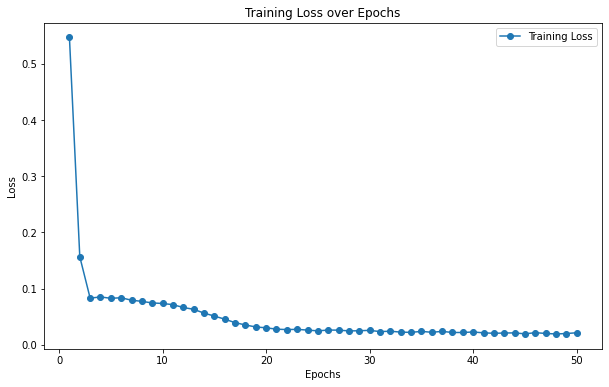

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

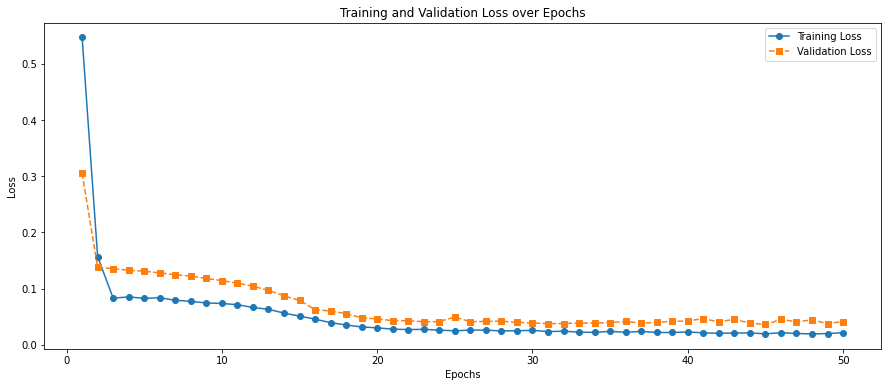

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Kara_model_LT6/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 15ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.17324375977851608
MAE : 0.15484115537193158


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,306653.875000,131973.043
1,570740.000000,753595.099
2,764304.750000,909176.475
3,806833.187500,917006.278
4,814099.687500,906368.363
5,790830.625000,917403.622
6,765602.812500,910653.838
7,699896.562500,822319.125
8,573806.437500,557314.102
9,406240.843750,197129.525


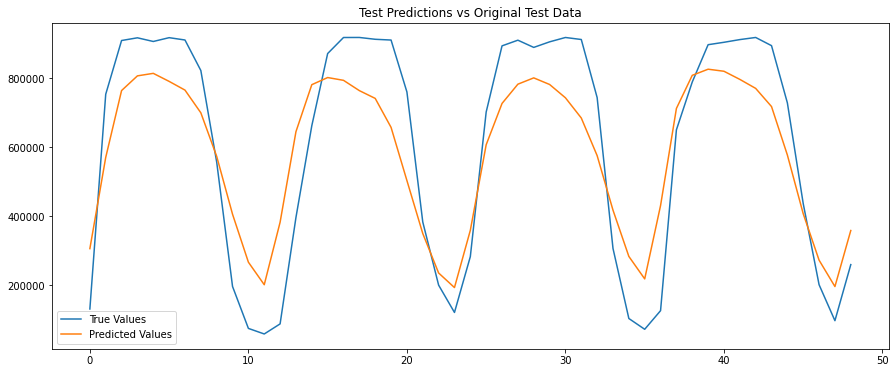

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 14ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

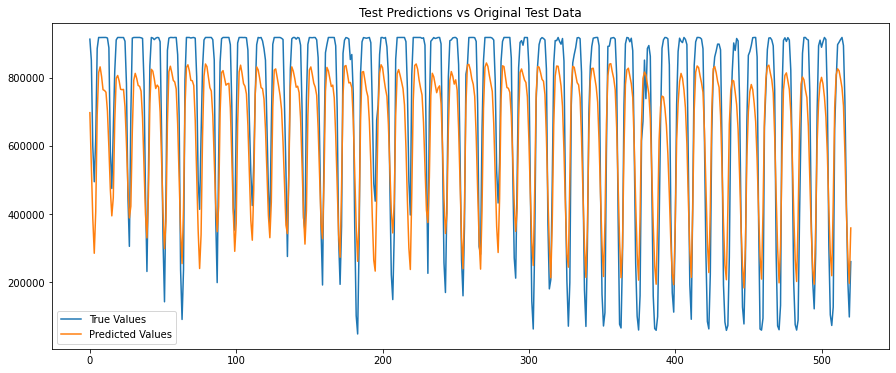

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()